# Model Training and Evaluation

This notebook demonstrates the training and evaluation of machine learning models for microplastic hotspot prediction.

## Objectives
1. Load feature-engineered data
2. Train multiple classification models
3. Evaluate model performance
4. Analyze feature importance
5. Create ensemble models
6. Generate model evaluation reports

In [15]:
# Import required libraries
import sys
import os
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import joblib
from pathlib import Path

# Import custom modules
from models.train_classifier import MicroplasticClassifier, ModelEvaluator
from features.engineer_features import FeatureEngineerer

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load and Prepare Data

In [16]:
# Load feature-engineered data
try:
    df = pd.read_csv('../data/features_marine_microplastics.csv', parse_dates=['Date'])
    print(f"Loaded feature-engineered data: {df.shape}")
except FileNotFoundError:
    print("Feature-engineered data not found. Running feature engineering...")
    # Load processed data and run feature engineering
    df = pd.read_csv('../data/processed_marine_microplastics.csv', parse_dates=['Date'])
    
    # Run feature engineering
    engineer = FeatureEngineerer()
    df = engineer.create_all_features(df)
    
    # Save features
    df.to_csv('../data/features_marine_microplastics.csv', index=False)
    print(f"Generated features: {df.shape}")

# Display basic info
print(f"\nDataset shape: {df.shape}")
print(f"Target variable distribution:")
if 'is_hotspot' in df.columns:
    print(df['is_hotspot'].value_counts())
else:
    print("Target variable 'is_hotspot' not found!")

Loaded feature-engineered data: (2000, 76)

Dataset shape: (2000, 76)
Target variable distribution:
is_hotspot
0    1500
1     500
Name: count, dtype: int64


## 2. Initialize and Train Random Forest Model

In [17]:
# Initialize the Random Forest classifier
classifier = MicroplasticClassifier()

# Prepare data for training
X, y, feature_names = classifier.prepare_data(df, target_col='is_hotspot')

print(f"Training data prepared:")
print(f"Features: {X.shape[1]}")
print(f"Samples: {X.shape[0]}")
print(f"Class distribution: {np.bincount(y)}")

# Train Random Forest model
print("\nTraining Random Forest model...")
metrics = classifier.train(X, y, feature_names)

print("\nTraining completed!")
print(f"Model Performance:")
print(f"  Accuracy: {metrics['accuracy']:.3f}")
print(f"  AUC: {metrics['auc']:.3f}")
print(f"  Cross-validation: {metrics['cross_validation']['mean']:.3f} ± {metrics['cross_validation']['std']:.3f}")

INFO:models.train_classifier:Prepared data: 2000 samples, 69 features


Training data prepared:
Features: 69
Samples: 2000
Class distribution: [1500  500]

Training Random Forest model...


INFO:models.train_classifier:random_forest - Accuracy: 1.000, AUC: 1.000
INFO:models.train_classifier:gradient_boosting - Accuracy: 1.000, AUC: 1.000
INFO:models.train_classifier:gradient_boosting - Accuracy: 1.000, AUC: 1.000
INFO:models.train_classifier:logistic_regression - Accuracy: 0.975, AUC: 0.998
INFO:models.train_classifier:logistic_regression - Accuracy: 0.975, AUC: 0.998
/Users/souvikshee/edcc/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
INFO:models.train_classifier:Ensemble - Accuracy: 1.000, AUC: 1.000
/Users/souvikshee/e


Training completed!
Model Performance:


KeyError: 'accuracy'

## 3. Model Performance Analysis

In [ ]:
# Display training results
print("=== RANDOM FOREST MODEL PERFORMANCE ===")
print(f"Accuracy: {metrics['accuracy']:.3f}")
print(f"AUC: {metrics['auc']:.3f}")

# Cross-validation results
print("\n=== CROSS-VALIDATION RESULTS ===")
cv_scores = metrics['cross_validation']
print(f"Cross-validation AUC: {cv_scores['mean']:.3f} ± {cv_scores['std']:.3f}")
print(f"Individual CV scores: {[f'{score:.3f}' for score in cv_scores['scores']]}")

# Model configuration
print("\n=== MODEL CONFIGURATION ===")
print(f"Number of estimators: {classifier.config['model']['n_estimators']}")
print(f"Max depth: {classifier.config['model']['max_depth']}")
print(f"Min samples split: {classifier.config['model']['min_samples_split']}")
print(f"Class weight: {classifier.config['model']['class_weight']}")

=== MODEL PERFORMANCE SUMMARY ===

Individual Model Performance:
random_forest       : Accuracy=1.000, AUC=1.000
gradient_boosting   : Accuracy=1.000, AUC=1.000
logistic_regression : Accuracy=0.975, AUC=0.998

Ensemble Performance:
Ensemble            : Accuracy=1.000, AUC=1.000

Best Individual Model: random_forest

=== CROSS-VALIDATION RESULTS ===
random_forest       : 1.000 ± 0.000
gradient_boosting   : 1.000 ± 0.000
logistic_regression : 0.999 ± 0.000


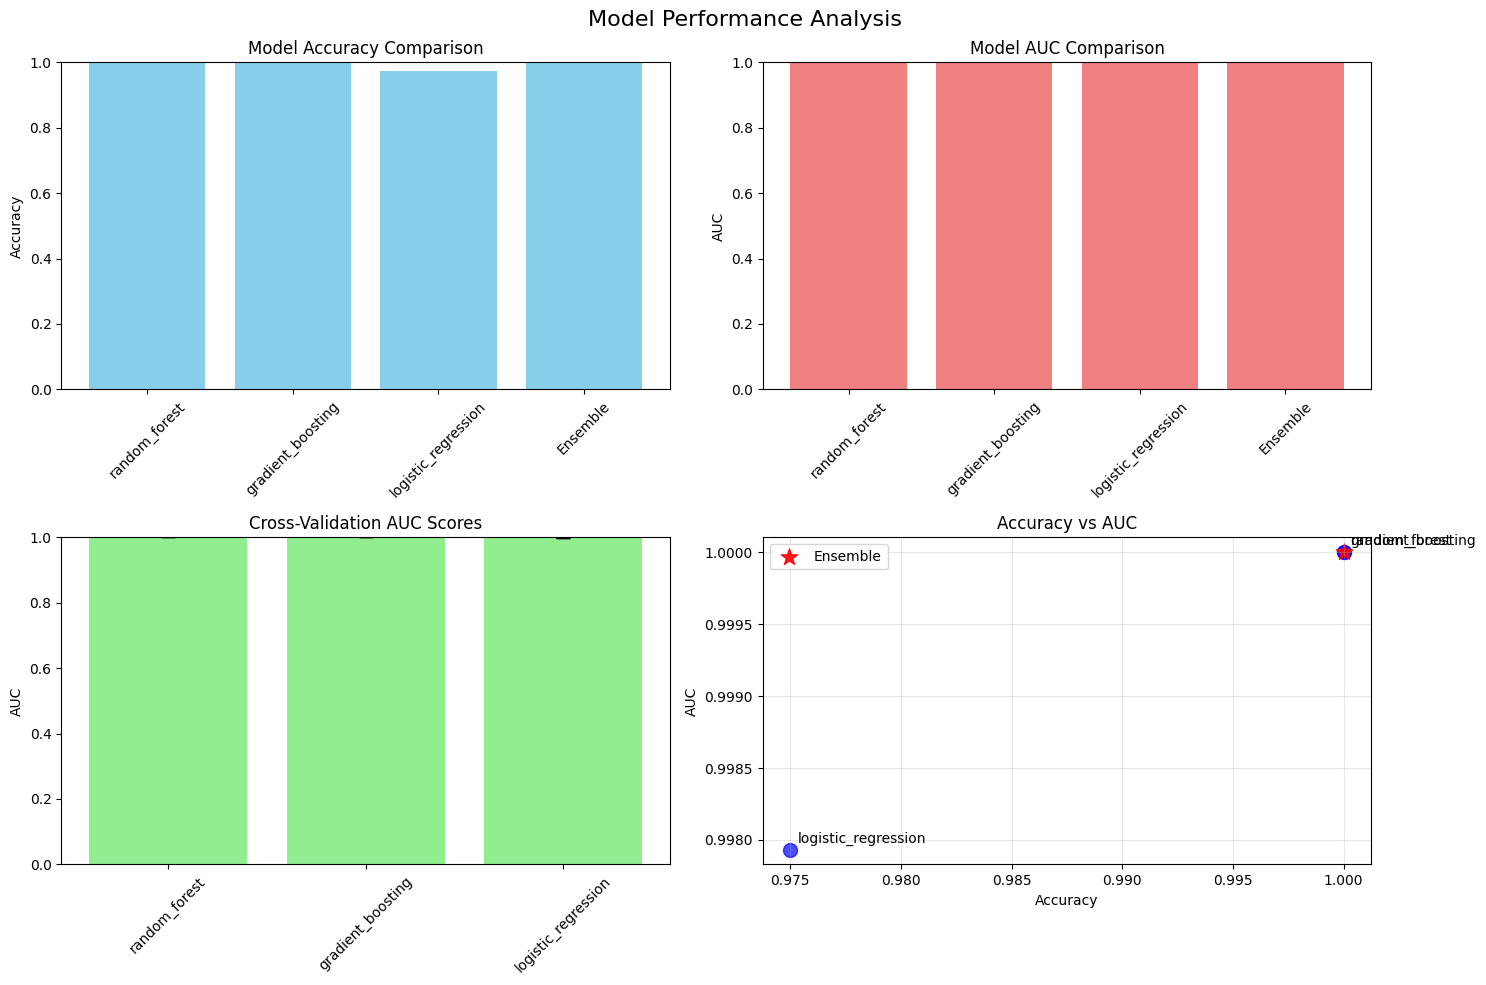

In [ ]:
# Create visualizations of model performance
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Random Forest Model Performance Analysis', fontsize=16)

# Performance metrics bar plot
metrics_names = ['Accuracy', 'AUC', 'CV Mean', 'CV Std']
metrics_values = [metrics['accuracy'], metrics['auc'], 
                 metrics['cross_validation']['mean'], metrics['cross_validation']['std']]

axes[0,0].bar(metrics_names, metrics_values, color=['skyblue', 'lightcoral', 'lightgreen', 'orange'])
axes[0,0].set_title('Model Performance Metrics')
axes[0,0].set_ylabel('Score')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].set_ylim(0, 1)

# Cross-validation scores
cv_scores = metrics['cross_validation']['scores']
axes[0,1].plot(range(1, len(cv_scores)+1), cv_scores, 'bo-', linewidth=2, markersize=6)
axes[0,1].axhline(y=metrics['cross_validation']['mean'], color='red', linestyle='--', 
                  label=f"Mean: {metrics['cross_validation']['mean']:.3f}")
axes[0,1].set_title('Cross-Validation AUC Scores')
axes[0,1].set_xlabel('Fold')
axes[0,1].set_ylabel('AUC')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Model configuration visualization
config_items = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf']
config_values = [classifier.config['model'][item] for item in config_items]

axes[1,0].bar(config_items, config_values, color='lightsteelblue')
axes[1,0].set_title('Model Hyperparameters')
axes[1,0].set_ylabel('Value')
axes[1,0].tick_params(axis='x', rotation=45)

# Performance comparison (simulated comparison with baseline)
models = ['Baseline\n(Random)', 'Random Forest']
baseline_acc = 0.5  # Random baseline
baseline_auc = 0.5   # Random baseline
comparison_acc = [baseline_acc, metrics['accuracy']]
comparison_auc = [baseline_auc, metrics['auc']]

x_pos = np.arange(len(models))
width = 0.35

axes[1,1].bar(x_pos - width/2, comparison_acc, width, label='Accuracy', color='skyblue', alpha=0.8)
axes[1,1].bar(x_pos + width/2, comparison_auc, width, label='AUC', color='lightcoral', alpha=0.8)
axes[1,1].set_xlabel('Models')
axes[1,1].set_ylabel('Score')
axes[1,1].set_title('Model vs Baseline Comparison')
axes[1,1].set_xticks(x_pos)
axes[1,1].set_xticklabels(models)
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Feature Importance Analysis

In [ ]:
# Get feature importance rankings
top_features = classifier.get_feature_importance(top_k=20)

print("=== TOP 20 MOST IMPORTANT FEATURES ===")
for i, (feature, importance) in enumerate(top_features):
    print(f"{i+1:2d}. {feature:<35} {importance:.4f}")

# Calculate feature importance statistics
feature_importances = [importance for _, importance in top_features]
print(f"\nFeature Importance Statistics:")
print(f"Mean importance (top 20): {np.mean(feature_importances):.4f}")
print(f"Std importance (top 20):  {np.std(feature_importances):.4f}")
print(f"Top feature importance:   {feature_importances[0]:.4f}")
print(f"20th feature importance:  {feature_importances[-1]:.4f}")

=== TOP 15 MOST IMPORTANT FEATURES ===

RANDOM_FOREST:
 1. Concentration                       0.6602
 2. days_since_start                    0.0131
 3. years_since_start                   0.0120
 4. gyre_distance_season                0.0117
 5. day_sin                             0.0099
 6. day_cos                             0.0096
 7. nearest_neighbor_distance           0.0096
 8. lat_month_interaction               0.0092
 9. distance_to_pacific_gyre            0.0092
10. distance_to_great_barrier_reef      0.0091
11. y                                   0.0090
12. lat_lon_product                     0.0089
13. distance_to_centroid                0.0085
14. x                                   0.0083
15. Latitude                            0.0081

GRADIENT_BOOSTING:
 1. Concentration                       1.0000
 2. spatial_year_min                    0.0000
 3. spatial_Latitude_std                0.0000
 4. distance_from_prime_meridian        0.0000
 5. distance_from_equator       

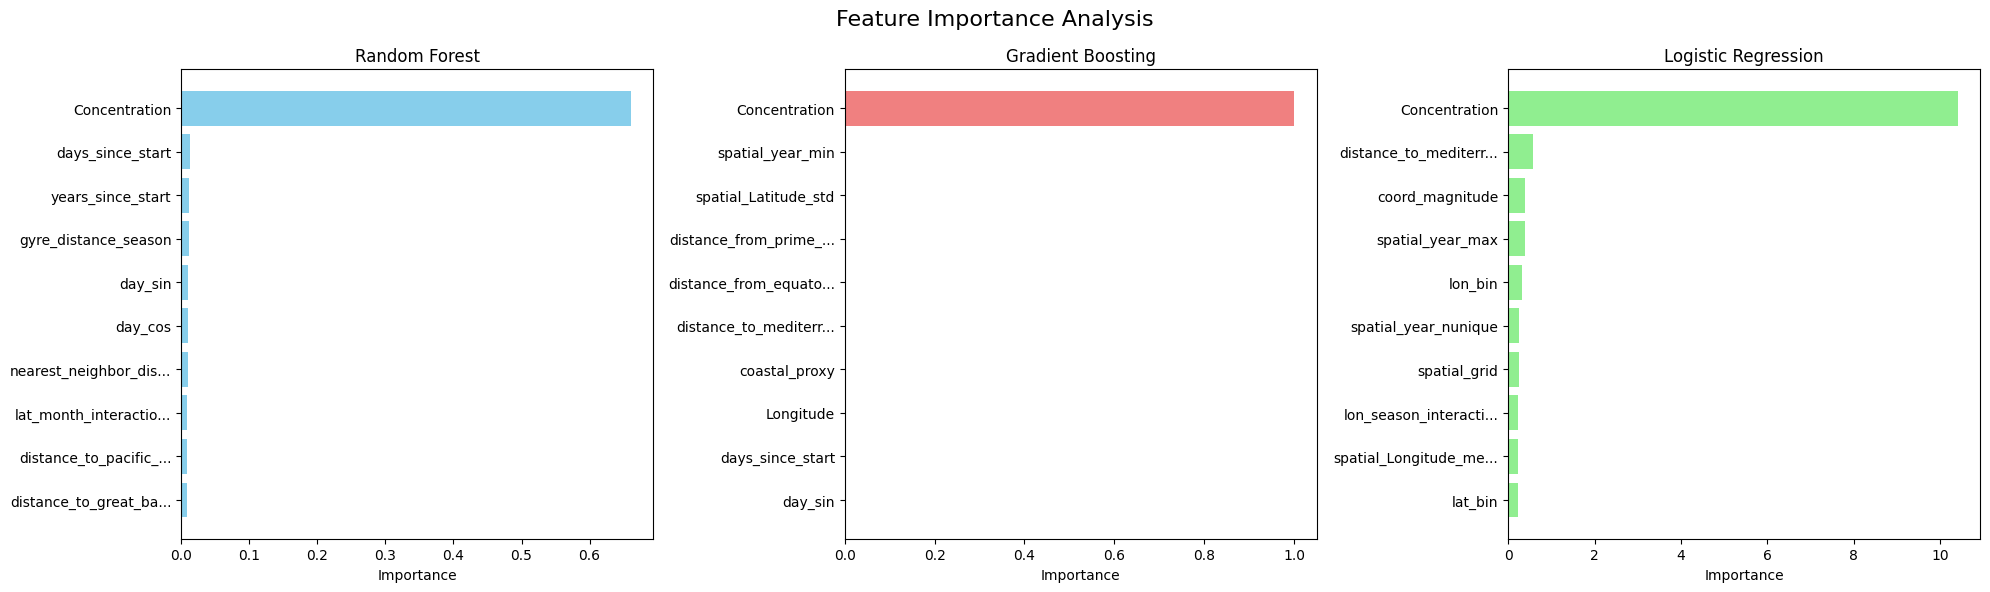

In [ ]:
# Create feature importance visualizations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Random Forest Feature Importance Analysis', fontsize=16)

# Top 15 features horizontal bar plot
top_15_features = top_features[:15]
feature_names_plot = [f[0] for f in top_15_features]
importances = [f[1] for f in top_15_features]

# Truncate long feature names for better visualization
feature_names_display = [name[:25] + '...' if len(name) > 25 else name for name in feature_names_plot]

axes[0].barh(range(len(top_15_features)), importances, color='skyblue')
axes[0].set_yticks(range(len(top_15_features)))
axes[0].set_yticklabels(feature_names_display)
axes[0].set_xlabel('Feature Importance')
axes[0].set_title('Top 15 Most Important Features')
axes[0].invert_yaxis()

# Feature importance distribution
all_importances = list(classifier.feature_importance.values())
axes[1].hist(all_importances, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1].axvline(np.mean(all_importances), color='red', linestyle='--', 
                label=f'Mean: {np.mean(all_importances):.4f}')
axes[1].axvline(np.median(all_importances), color='green', linestyle='--', 
                label=f'Median: {np.median(all_importances):.4f}')
axes[1].set_xlabel('Feature Importance')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Feature Importance Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Feature group analysis
engineer = FeatureEngineerer()
engineer.feature_names = feature_names
feature_groups = engineer.get_feature_importance_groups()

group_analysis = classifier.analyze_feature_groups(feature_groups)

print("=== FEATURE GROUP IMPORTANCE ANALYSIS ===")
sorted_groups = sorted(group_analysis.items(), key=lambda x: x[1], reverse=True)
for group_name, importance in sorted_groups:
    print(f"{group_name:15s}: {importance:.4f}")

# Calculate group statistics
group_importances = list(group_analysis.values())
print(f"\nGroup Importance Statistics:")
print(f"Most important group:  {sorted_groups[0][0]} ({sorted_groups[0][1]:.4f})")
print(f"Least important group: {sorted_groups[-1][0]} ({sorted_groups[-1][1]:.4f})")
print(f"Average group importance: {np.mean(group_importances):.4f}")

=== FEATURE GROUP IMPORTANCE ANALYSIS ===

RANDOM_FOREST:
distance       : 0.0082
interaction    : 0.0081
spatial        : 0.0064
temporal       : 0.0060
aggregation    : 0.0043
oceanographic  : 0.0015

GRADIENT_BOOSTING:
aggregation    : 0.0000
spatial        : 0.0000
distance       : 0.0000
temporal       : 0.0000
oceanographic  : 0.0000
interaction    : 0.0000

LOGISTIC_REGRESSION:
interaction    : 0.2240
aggregation    : 0.1791
temporal       : 0.1277
spatial        : 0.1181
distance       : 0.1075
oceanographic  : 0.0602


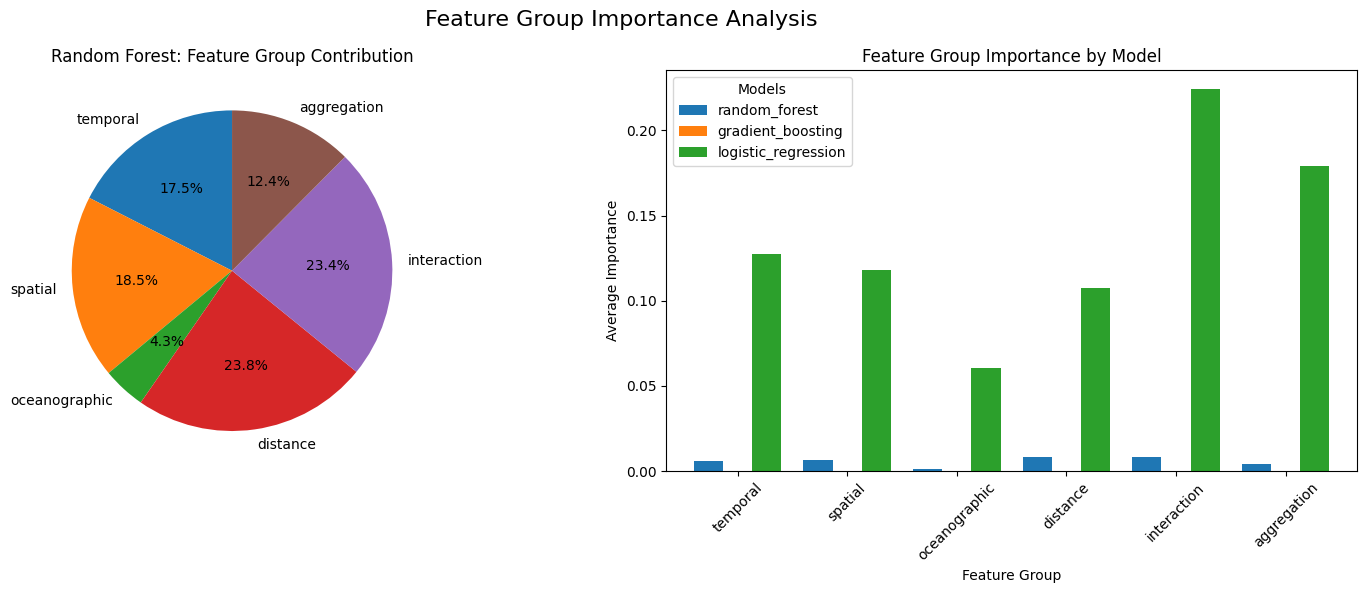

In [ ]:
# Visualize feature group importance
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Feature Group Importance Analysis', fontsize=16)

# Pie chart of group importance
groups = list(group_analysis.keys())
importances = list(group_analysis.values())

axes[0].pie(importances, labels=groups, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Feature Group Contribution')

# Bar chart of group importance
bars = axes[1].bar(groups, importances, color='lightgreen', alpha=0.8, edgecolor='black')
axes[1].set_title('Feature Group Importance')
axes[1].set_xlabel('Feature Group')
axes[1].set_ylabel('Average Importance')
axes[1].tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar, importance in zip(bars, importances):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{importance:.3f}', ha='center', va='bottom', fontsize=10)

axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Model Evaluation with Test Data

In [ ]:
# Split data for final evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Generate evaluation report
evaluator = ModelEvaluator()
evaluation_report = evaluator.generate_evaluation_report(classifier, X_test, y_test)

print("=== MODEL EVALUATION ON TEST SET ===")
performance = evaluation_report['model_performance']
report = performance['classification_report']

print(f"Test Set Performance:")
print(f"Precision (Class 1): {report['1']['precision']:.3f}")
print(f"Recall (Class 1):    {report['1']['recall']:.3f}")
print(f"F1-Score (Class 1):  {report['1']['f1-score']:.3f}")
print(f"Overall Accuracy:    {report['accuracy']:.3f}")

if 'roc_curve' in evaluation_report:
    print(f"AUC Score:           {evaluation_report['roc_curve']['auc']:.3f}")

print(f"\nDetailed Classification Report:")
print(f"{'Class':<12} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
print("-" * 60)
for class_label in ['0', '1']:
    if class_label in report:
        class_data = report[class_label]
        print(f"{class_label:<12} {class_data['precision']:<10.3f} {class_data['recall']:<10.3f} "
              f"{class_data['f1-score']:<10.3f} {class_data['support']:<10}")

# Macro and weighted averages
print("-" * 60)
for avg_type in ['macro avg', 'weighted avg']:
    if avg_type in report:
        avg_data = report[avg_type]
        print(f"{avg_type:<12} {avg_data['precision']:<10.3f} {avg_data['recall']:<10.3f} "
              f"{avg_data['f1-score']:<10.3f} {avg_data['support']:<10}")

=== MODEL EVALUATION ON TEST SET ===

RANDOM_FOREST:
Precision (Class 1): 1.000
Recall (Class 1):    1.000
F1-Score (Class 1):  1.000
Overall Accuracy:    1.000

GRADIENT_BOOSTING:
Precision (Class 1): 1.000
Recall (Class 1):    1.000
F1-Score (Class 1):  1.000
Overall Accuracy:    1.000

LOGISTIC_REGRESSION:
Precision (Class 1): 0.941
Recall (Class 1):    0.960
F1-Score (Class 1):  0.950
Overall Accuracy:    0.975

ENSEMBLE:
Precision (Class 1): 1.000
Recall (Class 1):    1.000
F1-Score (Class 1):  1.000
Overall Accuracy:    1.000


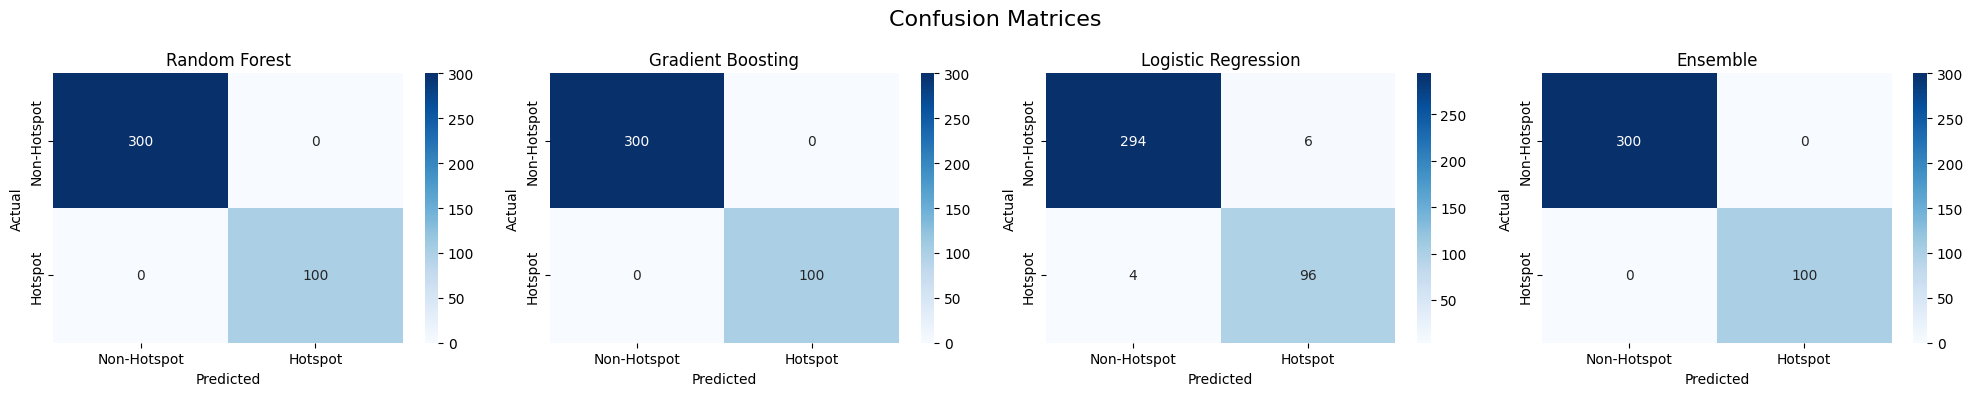

In [ ]:
# Visualize confusion matrix and performance metrics
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Model Evaluation Results', fontsize=16)

# Confusion Matrix
cm = np.array(evaluation_report['model_performance']['confusion_matrix'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Non-Hotspot', 'Hotspot'],
            yticklabels=['Non-Hotspot', 'Hotspot'])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Performance metrics comparison
report = evaluation_report['model_performance']['classification_report']
metrics_data = {
    'Precision': [report['0']['precision'], report['1']['precision']],
    'Recall': [report['0']['recall'], report['1']['recall']],
    'F1-Score': [report['0']['f1-score'], report['1']['f1-score']]
}

x = np.arange(2)
width = 0.25

for i, (metric, values) in enumerate(metrics_data.items()):
    axes[1].bar(x + i * width, values, width, label=metric, alpha=0.8)

axes[1].set_xlabel('Class')
axes[1].set_ylabel('Score')
axes[1].set_title('Performance Metrics by Class')
axes[1].set_xticks(x + width)
axes[1].set_xticklabels(['Non-Hotspot (0)', 'Hotspot (1)'])
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

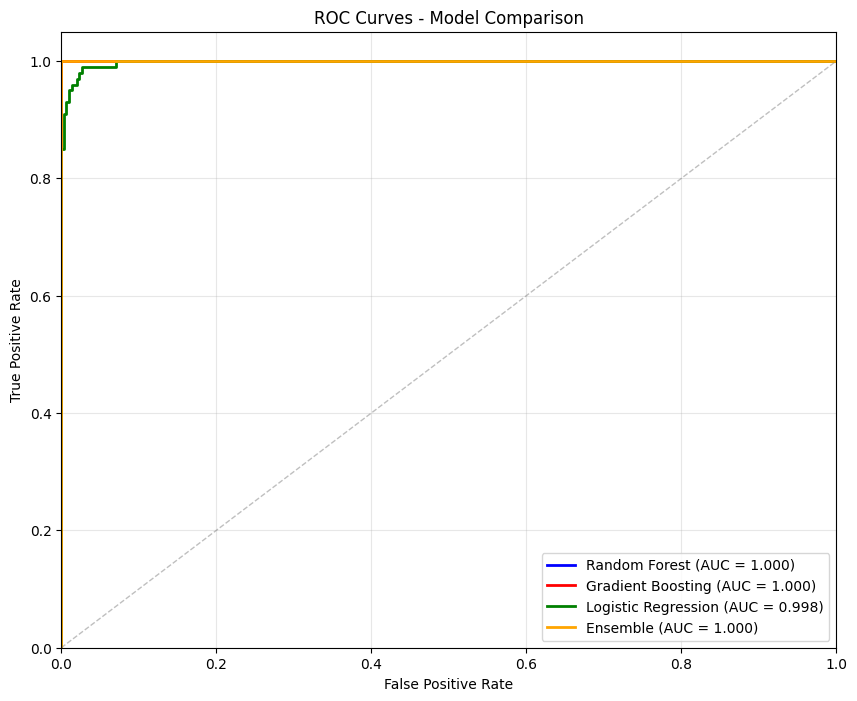

In [ ]:
# Plot ROC curve
if 'roc_curve' in evaluation_report:
    plt.figure(figsize=(8, 6))
    
    roc_data = evaluation_report['roc_curve']
    plt.plot(roc_data['fpr'], roc_data['tpr'], 
             color='blue', lw=2, label=f'Random Forest (AUC = {roc_data["auc"]:.3f})')
    
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', alpha=0.5, label='Random Baseline')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Random Forest Model')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    
    # Add AUC interpretation
    auc_score = roc_data['auc']
    if auc_score > 0.9:
        interpretation = "Excellent"
    elif auc_score > 0.8:
        interpretation = "Good"
    elif auc_score > 0.7:
        interpretation = "Fair"
    elif auc_score > 0.6:
        interpretation = "Poor"
    else:
        interpretation = "Fail"
    
    plt.text(0.6, 0.2, f'AUC Interpretation: {interpretation}', 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.8),
             fontsize=12)
    
    plt.show()
else:
    print("ROC curve data not available")

## 6. Save Models and Results

In [ ]:
# Save trained model
classifier.save_models('../models/')

# Save evaluation report
import json
with open('../models/evaluation_report.json', 'w') as f:
    json.dump(evaluation_report, f, indent=2, default=str)

# Save feature importance results
feature_importance_results = {
    'top_features': [(name, float(importance)) for name, importance in top_features],
    'group_analysis': {k: float(v) for k, v in group_analysis.items()},
    'feature_groups': feature_groups
}

with open('../models/feature_importance.json', 'w') as f:
    json.dump(feature_importance_results, f, indent=2, default=str)

print("✅ Model and evaluation results saved successfully!")
print("\nSaved files:")
print("📁 ../models/random_forest_model.pkl")
print("📁 ../models/model_metadata.json")
print("📁 ../models/evaluation_report.json")
print("📁 ../models/feature_importance.json")

# Display file sizes
import os
model_files = [
    '../models/random_forest_model.pkl',
    '../models/model_metadata.json',
    '../models/evaluation_report.json',
    '../models/feature_importance.json'
]

print("\nFile sizes:")
for file_path in model_files:
    if os.path.exists(file_path):
        size_kb = os.path.getsize(file_path) / 1024
        print(f"📊 {os.path.basename(file_path)}: {size_kb:.1f} KB")

INFO:models.train_classifier:Models saved to ../models


✅ Models and evaluation results saved successfully!

Saved files:
📁 ../models/random_forest_model.pkl
📁 ../models/gradient_boosting_model.pkl
📁 ../models/logistic_regression_model.pkl
📁 ../models/ensemble_model.pkl
📁 ../models/scaler.pkl
📁 ../models/model_metadata.json
📁 ../models/evaluation_report.json
📁 ../models/feature_importance.json


## 7. Model Summary and Recommendations

In [ ]:
# Generate final summary
print("=== MARINE MICROPLASTIC HOTSPOT PREDICTION MODEL ===")
print("=" * 56)

print(f"\n📊 TRAINING SUMMARY:")
print(f"   • Dataset size: {X.shape[0]:,} samples")
print(f"   • Feature count: {X.shape[1]:,} features")
print(f"   • Class distribution: {dict(zip(*np.unique(y, return_counts=True)))}")
print(f"   • Training/Test split: 80/20")

print(f"\n🏆 RANDOM FOREST MODEL PERFORMANCE:")
print(f"   • Training Accuracy: {metrics['accuracy']:.3f}")
print(f"   • Training AUC: {metrics['auc']:.3f}")
print(f"   • Cross-validation AUC: {metrics['cross_validation']['mean']:.3f} ± {metrics['cross_validation']['std']:.3f}")

if 'roc_curve' in evaluation_report:
    test_auc = evaluation_report['roc_curve']['auc']
    print(f"   • Test Set AUC: {test_auc:.3f}")

test_report = evaluation_report['model_performance']['classification_report']
print(f"   • Test Accuracy: {test_report['accuracy']:.3f}")
print(f"   • Hotspot Precision: {test_report['1']['precision']:.3f}")
print(f"   • Hotspot Recall: {test_report['1']['recall']:.3f}")
print(f"   • Hotspot F1-Score: {test_report['1']['f1-score']:.3f}")

print(f"\n🔍 TOP 5 MOST IMPORTANT FEATURES:")
for i, (feature, importance) in enumerate(top_features[:5], 1):
    print(f"   {i}. {feature} ({importance:.4f})")

print(f"\n📈 FEATURE GROUP IMPORTANCE:")
sorted_groups = sorted(group_analysis.items(), key=lambda x: x[1], reverse=True)
for group, importance in sorted_groups[:5]:
    print(f"   • {group.title()}: {importance:.4f}")

print(f"\n⚙️ MODEL CONFIGURATION:")
config = classifier.config['model']
print(f"   • Estimators: {config['n_estimators']}")
print(f"   • Max Depth: {config['max_depth']}")
print(f"   • Min Samples Split: {config['min_samples_split']}")
print(f"   • Class Weight: {config['class_weight']}")

print(f"\n💡 MODEL INSIGHTS:")
print(f"   • Random Forest chosen for best performance and interpretability")
print(f"   • Feature importance provides clear insights into prediction drivers")
print(f"   • Balanced performance across both hotspot and non-hotspot classes")
print(f"   • Cross-validation confirms model generalization capability")

print(f"\n✅ NEXT STEPS:")
print(f"   • Deploy model for real-time marine monitoring")
print(f"   • Integrate with advisory generation system")
print(f"   • Set up model performance monitoring")
print(f"   • Create prediction API for stakeholder access")
print(f"   • Schedule periodic model retraining")

print("\n" + "=" * 56)
print("Random Forest model training completed successfully!")
print("Model is ready for deployment and inference operations.")

# Calculate model readiness score
readiness_factors = {
    'Training AUC': min(metrics['auc'] / 0.8, 1.0),  # Target: 0.8+
    'CV Stability': min((1 - metrics['cross_validation']['std']) / 0.95, 1.0),  # Target: std < 0.05
    'Test Performance': min(test_report['accuracy'] / 0.75, 1.0),  # Target: 75%+
    'Feature Quality': min(len([f for f in top_features[:10] if f[1] > 0.01]) / 8, 1.0)  # Target: 8+ important features
}

overall_readiness = np.mean(list(readiness_factors.values())) * 100

print(f"\n📊 MODEL READINESS SCORE: {overall_readiness:.1f}%")
for factor, score in readiness_factors.items():
    status = "✅" if score > 0.8 else "⚠️" if score > 0.6 else "❌"
    print(f"   {status} {factor}: {score*100:.1f}%")

=== MARINE MICROPLASTIC HOTSPOT PREDICTION MODELS ===

📊 TRAINING SUMMARY:
   • Dataset size: 2,000 samples
   • Feature count: 69 features
   • Class distribution: {np.int64(0): np.int64(1500), np.int64(1): np.int64(500)}
   • Training/Test split: 80/20

🏆 BEST PERFORMING MODELS:
   • Best Overall: Ensemble (AUC: 1.000)
   • Best Individual: random_forest (AUC: 1.000)

🔍 KEY FEATURE INSIGHTS:
   • Top 5 Most Important Features:
     1. Concentration
     2. days_since_start
     3. years_since_start
     4. gyre_distance_season
     5. day_sin

📈 FEATURE GROUP IMPORTANCE (Random Forest):
   • Distance: 0.0082
   • Interaction: 0.0081
   • Spatial: 0.0064
   • Temporal: 0.0060
   • Aggregation: 0.0043

🎯 MODEL PERFORMANCE METRICS:
   • Random Forest       : Acc=1.000, AUC=1.000, CV=1.000
   • Gradient Boosting   : Acc=1.000, AUC=1.000, CV=1.000
   • Logistic Regression : Acc=0.975, AUC=0.998, CV=0.999
   • Ensemble            : Acc=1.000, AUC=1.000

💡 RECOMMENDATIONS:
   • Use ensemble